# GenCode Explore

Explore the human RNA sequences from GenCode.

Assume user downloaded files from GenCode 38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

Improve on GenCode_Explore_101.ipynb

Use ORF_counter. 

Use MatPlotLib to make box plots and heat maps.

In [1]:
import time 
def show_time():
    t = time.time()
    s = time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))
    print(s)
show_time()

2021-06-08 16:48:03 UTC


In [2]:
import numpy as np
import pandas as pd
import gzip
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    from RNA_describe import *
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/Plot_Generator.py')
    with open('Plot_Generator.py', 'w') as f:
      f. write(s.text)
    from Plot_Generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.Plot_Generator import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Mounted at /content/drive/


In [3]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'

In [4]:
def load_gencode(filename,label):
    DEFLINE='>'
    DELIM='|'
    EMPTY=''
    labels=[]  # usually 1 for protein-coding or 0 for non-coding
    seqs=[]    # usually string of ACGT
    lens=[]    # sequence length
    ids=[]     # GenCode transcript ID, always starts ENST
    one_seq = EMPTY
    one_id = None
    # Use gzip 'r' mode to open file in read-only mode.
    # Use gzip 't' mode to read each line of text as type string.
    with gzip.open (filename,'rt') as infile:
        for line in infile:
            if line[0]==DEFLINE:
                # Save the previous sequence if one exists.
                if not one_seq == EMPTY:
                    labels.append(label)
                    seqs.append(one_seq)
                    lens.append(len(one_seq))
                    ids.append(one_id)
                # Get ready to read the next sequence. 
                # Parse a GenCode defline that is formatted like this:
                # >transcript_ID|gene_ID|other_fields other_info|other_info
                one_id = line[1:].split(DELIM)[0]
                one_seq = EMPTY
            else:
                # Continue loading sequence lines till next defline.
                additional = line.rstrip()
                one_seq = one_seq + additional
        # Don't forget to save the last sequence after end-of-file.
        if not one_seq == EMPTY:
            labels.append(label)
            seqs.append(one_seq)
            lens.append(len(one_seq))
            ids.append(one_id)

    df1=pd.DataFrame(ids,columns=['tid'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

In [5]:
def get_the_facts(seqs,verbose=False):
    oc = ORF_counter()
    count = len(seqs)
    max_orf_lengths=np.zeros(count)
    for s in range(0,count):
        seq = seqs[s]
        oc.set_sequence(seq)
        max_orf = oc.get_max_orf_len()
        max_orf_lengths[s] = max_orf
    mean_max_orf = np.mean(max_orf_lengths,axis=0)
    std_max_orf = np.std(max_orf_lengths,axis=0)
    if verbose:
        print("mean longest ORF length:",int(mean_max_orf),"+/-",int(std_max_orf))
    return mean_max_orf

## Load the GenCode data.
Warning: GenCode has
over 100K protein-coding RNA (mRNA) 
and almost 50K non-coding RNA (lncRNA).

In [6]:
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
show_time()
pcdf=load_gencode(PC_FULLPATH,1)
print("PC seqs loaded:",len(pcdf))
show_time()
ncdf=load_gencode(NC_FULLPATH,0)
print("NC seqs loaded:",len(ncdf))
show_time()

2021-06-08 16:48:23 UTC
PC seqs loaded: 106143
2021-06-08 16:48:29 UTC
NC seqs loaded: 48752
2021-06-08 16:48:30 UTC


In [7]:
print("Sorting PC...")
pcdf.sort_values('seqlen', ascending=True, inplace=True)
print("Sorting NC...")
ncdf.sort_values('seqlen', ascending=True, inplace=True)

Sorting PC...
Sorting NC...


In [8]:
# This is a fast way to slice if you have length thresholds.
# TO DO: choose length thresholds and apply to PC and NC RNA.
# For example: 200, 400, 800, 1600, 3200, 6400 (e.g. 200-399, etc.)
#mask = (ncdf['sequence'].str.len() < 1000)
#subset = ncdf.loc[mask]

# Here is one way to extract a list from a dataframe. 
#mylist=subset['sequence'].tolist()

#TODO: filter out sequences less than 200 here?

###Bin sequences by length

---

In [9]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) < max_len, input_list))

In [10]:
bins = [(200, 400), (400, 800), (800, 1600), (1600, 3200), (3200, 6400), (6400, 12800), (12800, 25600), (25600, 51200)]
num_bins = len(bins)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#Bin the RNA sequences
binned_pc_sequences = []
binned_nc_sequences = []
for i in range(0, num_bins):
  bin = bins[i]
  binned_pc_sequences.append([])
  binned_nc_sequences.append([])
  binned_pc_sequences[i] = subset_list_by_len_bounds(pcdf['sequence'].tolist(), bin[0], bin[1])
  binned_nc_sequences[i] = subset_list_by_len_bounds(ncdf['sequence'].tolist(), bin[0], bin[1])
show_time()

2021-06-08 16:48:31 UTC


##Gather data on ORF lengths and the number of contained and non-contained ORFs

---

In [12]:
pc_max_len_data = []
pc_max_cnt_data = []
pc_contain_data = []

nc_max_len_data = []
nc_max_cnt_data = []
nc_contain_data = []

oc = ORF_counter()

for bin_num in range(0, num_bins):
  #Gather protein-coding sequence data
  pc_max_len_data.append([])
  pc_max_cnt_data.append([])
  pc_contain_data.append([])
  for seq_num in range(0, len(binned_pc_sequences[bin_num])):
    oc.set_sequence(binned_pc_sequences[bin_num][seq_num])
    pc_max_len_data[bin_num].append(oc.get_max_orf_len())
    pc_max_cnt_data[bin_num].append(oc.count_maximal_orfs())
    pc_contain_data[bin_num].append(oc.count_contained_orfs())

  #Gather non-coding sequence data
  nc_max_len_data.append([])
  nc_max_cnt_data.append([])
  nc_contain_data.append([])
  for seq_num in range(0, len(binned_nc_sequences[bin_num])):
    oc.set_sequence(binned_nc_sequences[bin_num][seq_num])
    nc_max_len_data[bin_num].append(oc.get_max_orf_len())
    nc_max_cnt_data[bin_num].append(oc.count_maximal_orfs())
    nc_contain_data[bin_num].append(oc.count_contained_orfs())
show_time()

2021-06-08 16:49:55 UTC


##Prepare data for heatmap

---

In [13]:
def mean(data):
  return sum(data) / len(data)

In [14]:
#Get the means of all of the data
mean_pc_max_len_data = []
mean_pc_max_cnt_data = []
mean_pc_contain_data = []
mean_nc_max_len_data = []
mean_nc_max_cnt_data = []
mean_nc_contain_data = []
for i in range(0, num_bins):
  mean_pc_max_len_data.append(mean(pc_max_len_data[i]))
  mean_pc_max_cnt_data.append(mean(pc_max_cnt_data[i]))
  mean_pc_contain_data.append(mean(pc_contain_data[i]))
  mean_nc_max_len_data.append(mean(nc_max_len_data[i]))
  mean_nc_max_cnt_data.append(mean(nc_max_cnt_data[i]))
  mean_nc_contain_data.append(mean(nc_contain_data[i]))

#Combine them into a (6,6) shaped data set for the heatmap
hm_data = []
hm_data.append(mean_pc_max_len_data)
hm_data.append(mean_pc_max_cnt_data)
hm_data.append(mean_pc_contain_data)
hm_data.append(mean_nc_max_len_data)
hm_data.append(mean_nc_max_cnt_data)
hm_data.append(mean_nc_contain_data)

show_time()

2021-06-08 16:49:55 UTC


###Prepare data for plot of bin sizes

---

In [15]:
pc_bin_sizes = []
nc_bin_sizes = []
for i in range(0, num_bins):
  pc_bin_sizes.append(len(binned_pc_sequences[i]))
  nc_bin_sizes.append(len(binned_nc_sequences[i]))
show_time()

2021-06-08 16:49:55 UTC


###Prepare data for plot of number of sequences with no ORFs and plot of number of sequences with max ORF lengths equal to or less than 100

---

In [16]:
"""Counts the number of RNA sequences that fit the given constraints.
Sequence range constraints are exclusive.
Max ORF length constraints are inclusive,
"""
def count_constraint_valid_sequences(data, min_seq_len, max_seq_len, min_max_orf_len, max_max_orf_len):
  count = 0
  oc = ORF_counter()
  sequences = data['sequence'].tolist()
  for seq in sequences:
    if len(seq) > min_seq_len and len(seq) < max_seq_len:
      oc.set_sequence(seq)
      max_orf_len = oc.get_max_orf_len()
      if max_orf_len >= min_max_orf_len and max_orf_len <= max_max_orf_len:
        count += 1
  return count


In [17]:
pc_no_orf_count = []
nc_no_orf_count = []
for bin in bins:
  pc_no_orf_count.append(count_constraint_valid_sequences(pcdf, bin[0], bin[1], 0, 0))
  nc_no_orf_count.append(count_constraint_valid_sequences(ncdf, bin[0], bin[1], 0, 0))
show_time()

2021-06-08 16:51:21 UTC


In [18]:
pc_max_orf_len_less_than_100 = []
nc_max_orf_len_less_than_100 = []
for bin in bins:
  pc_max_orf_len_less_than_100.append(count_constraint_valid_sequences(pcdf, bin[0], bin[1], 0, 100))
  nc_max_orf_len_less_than_100.append(count_constraint_valid_sequences(ncdf, bin[0], bin[1], 0, 100))
show_time()

2021-06-08 16:52:46 UTC


###Prepare data for CDF plot of sequence lengths

---

In [19]:
pc_seqs = pcdf['sequence'].tolist()
nc_seqs = pcdf['sequence'].tolist()
pc_sequence_lengths = []
nc_sequence_lengths = []
for seq in pc_seqs:
  pc_sequence_lengths.append(len(seq))
for seq in nc_seqs:
  nc_sequence_lengths.append(len(seq))

## Plot the data

---

###Generate the plots

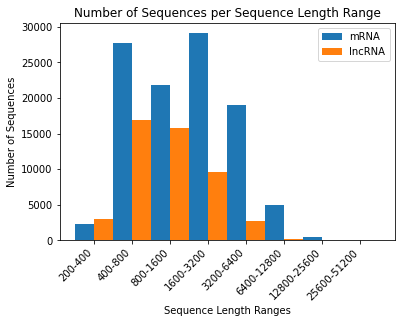

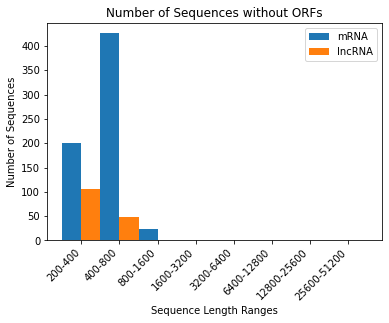

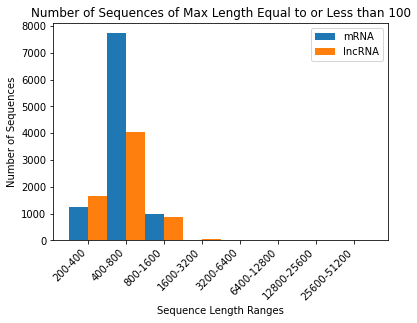

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


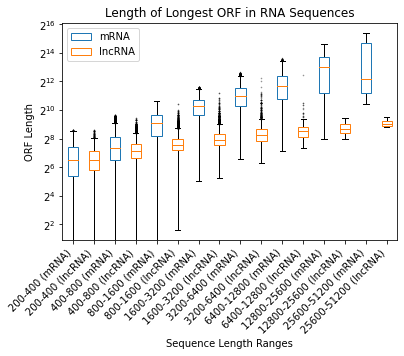

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


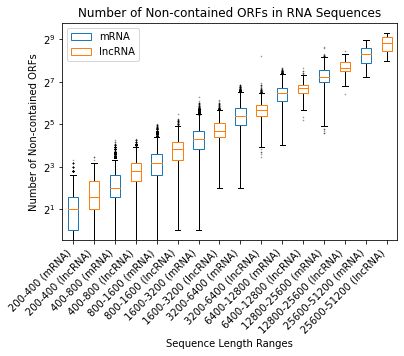

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


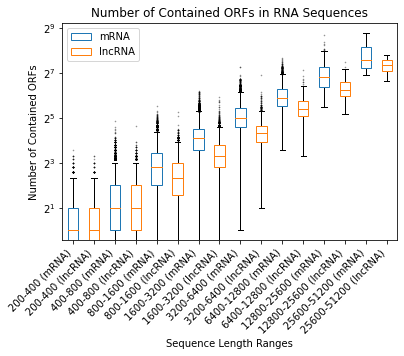

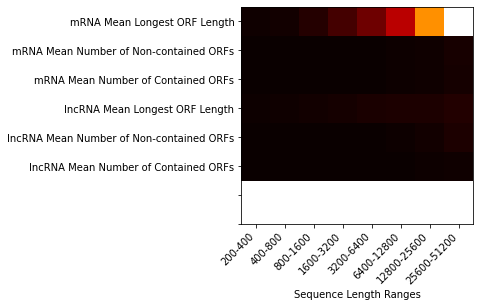

In [21]:
#Generate x-axis labels
x_axis_labels = []
for bin in bins:
  x_axis_labels.append(str(bin[0]) + "-" + str(bin[1]))

data_set_names = ['mRNA', 'lncRNA']

#Set up plot generator
pg = Plot_Generator()
pg.set_text_options(45, 'right', 0, 'center')

#Bar plots
pg.set_text('Number of Sequences per Sequence Length Range', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_bin_sizes, nc_bin_sizes], data_set_names)

pg.set_text('Number of Sequences without ORFs', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_no_orf_count, nc_no_orf_count], data_set_names)

pg.set_text('Number of Sequences of Max Length Equal to or Less than 100', 'Sequence Length Ranges', 'Number of Sequences', x_axis_labels, None)
pg.bar_plot([pc_max_orf_len_less_than_100, nc_max_orf_len_less_than_100], data_set_names)

#Box plots
pg.set_axis_options('linear', 10, 'log', 2)
pg.set_text('Length of Longest ORF in RNA Sequences', 'Sequence Length Ranges', 'ORF Length', x_axis_labels, None)
pg.box_plot([pc_max_len_data, nc_max_len_data], data_set_names, True)

pg.set_text('Number of Non-contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Non-contained ORFs', x_axis_labels, None)
pg.box_plot([pc_max_cnt_data, nc_max_cnt_data], data_set_names, True)

pg.set_text('Number of Contained ORFs in RNA Sequences', 'Sequence Length Ranges', 'Number of Contained ORFs', x_axis_labels, None)
pg.box_plot([pc_contain_data, nc_contain_data], data_set_names, True)

#Heatmap
plt.imshow(hm_data, cmap='hot', interpolation='nearest')
plt.xlabel('Sequence Length Ranges')
plt.xticks(np.arange(num_bins), x_axis_labels, rotation=45, ha='right')
plt.yticks(np.arange(num_bins), ["mRNA Mean Longest ORF Length", "mRNA Mean Number of Non-contained ORFs", "mRNA Mean Number of Contained ORFs", "lncRNA Mean Longest ORF Length", "lncRNA Mean Number of Non-contained ORFs", "lncRNA Mean Number of Contained ORFs"])
plt.show()

## Plotting examples
[boxplot doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html)  
[boxplot demo](https://matplotlib.org/stable/gallery/pyplots/boxplot_demo_pyplot.html)  
[heatmap examples](https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib) - scroll down!  